In [ ]:
%pylab inline

In [4]:
from pyspark import SparkContext, SparkConf
from datetime import datetime
from timeit import timeit


hello


In [2]:
tweetDataFrame = sqlContext.read.json('group_assignment/tweets/tweets_extended.json')
tweetDataFrame.printSchema()

root
 |-- created_at: long (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = tr

In [4]:
tweetDataFrame.registerTempTable('tweets')
sqlContext.sql('SELECT text FROM tweets').show()


+--------------------+
|                text|
+--------------------+
|RT @fotograaf: Li...|
|RT @UlrikNyman: @...|
|RT @mnmlstlife: C...|
|RT @IgorBrigadir:...|
|RT @AppintheAir: ...|
|Congrats @Virdata...|
|Kick-off of #rsta...|
|RT @StatFact: Dee...|
|RT @CourtCorley: ...|
|.@KirkDBorne @itk...|
|RT @_3s_: Looking...|
|RT @Protohedgehog...|
|Recap of #DMA14 D...|
|Recap of 2nd Day ...|
|RT @mkt_genius: Y...|
|I will be attendi...|
|www.mma.ugent.be ...|
|enjoyed his intro...|
|is getting ready ...|
|is getting ready ...|
+--------------------+
only showing top 20 rows



In [5]:
tweetDataFrame.take(1)

[Row(created_at=1422645502000L, entities=Row(hashtags=[Row(indices=[30, 36], text=u'Ghent'), Row(indices=[37, 45], text=u'Belgium'), Row(indices=[63, 77], text=u'lichtfestival'), Row(indices=[78, 83], text=u'gent')], media=[Row(display_url=u'pic.twitter.com/BPSQzwHQKT', expanded_url=u'http://twitter.com/fotograaf/status/561239153330106369/photo/1', id=561239129481314305L, id_str=u'561239129481314305', indices=[84, 106], media_url=u'http://pbs.twimg.com/media/B8nsA8LIgAEZWpP.jpg', media_url_https=u'https://pbs.twimg.com/media/B8nsA8LIgAEZWpP.jpg', sizes=[Row(h=1200, resize=u'fit', w=774), Row(h=1200, resize=u'fit', w=774), Row(h=527, resize=u'fit', w=340), Row(h=150, resize=u'crop', w=150), Row(h=930, resize=u'fit', w=600)], url=u'http://t.co/BPSQzwHQKT'), Row(display_url=u'pic.twitter.com/BPSQzwHQKT', expanded_url=u'http://twitter.com/fotograaf/status/561239153330106369/photo/1', id=561239152105369600L, id_str=u'561239152105369600', indices=[84, 106], media_url=u'http://pbs.twimg.com/m

In [7]:
sqlContext.sql('SELECT expanded_urls FROM tweets').show()

AnalysisException: cannot resolve 'expanded_urls' given input columns source, text, in_reply_to_status_id_str, in_reply_to_status_id, geo, retweeted_status, in_reply_to_user_id, entities, user, created_at, in_reply_to_user_id_str, id, id_str, in_reply_to_screen_name; line 1 pos 7

In [8]:
sqlContext.sql('SELECT COUNT(text) FROM tweets').show()

+----+
| _c0|
+----+
|2507|
+----+



(1, 12)

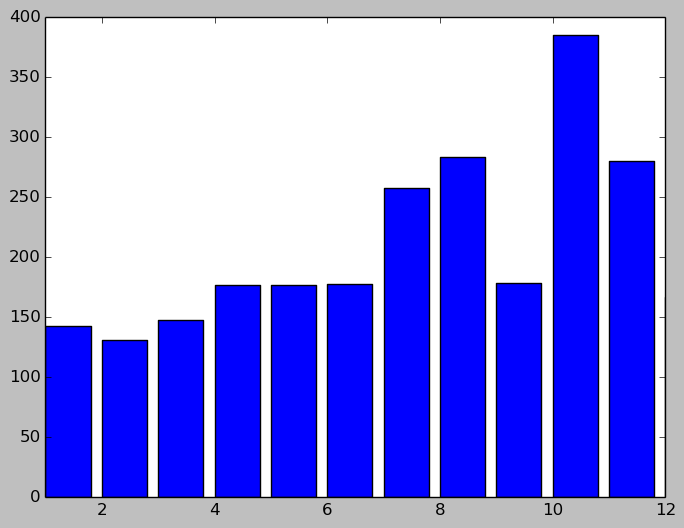

In [9]:
import datetime

dates = tweetDataFrame.select('created_at').map(lambda x: datetime.datetime.fromtimestamp(x[0] / 1e3))
dates = dates.groupBy(lambda x: x.month).sortByKey()
dates = dates.map(lambda x : (x[0], len(list(x[1])))).collect()
x,y = zip(*dates)

import matplotlib.pyplot as plt
plt.figure()
plt.bar(x,y)
plt.xlim(1,12)






In [157]:
import datetime
from pyspark.sql import Row
import numpy as np
"""
HELPER FUNCTIONS FOR retweets per tweets
"""
def aggregate_retweet_per_tweet(aggregated_dict, twitter_struct):
    if twitter_struct['id'] in aggregated_dict:
        aggregated_dict[twitter_struct['id']] += twitter_struct['retweet_number']
        return aggregated_dict
    
    aggregated_dict[twitter_struct['id']] = twitter_struct['retweet_number']
    return aggregated_dict
    
"""
execute
"""
retweets_per_tweet = tweetDataFrame.selectExpr('id','retweeted_status.id as r_id')
retweets_per_tweet = retweets_per_tweet.map(lambda x: {'id' : x.id, 'retweet_number' : 1 if x.r_id else 0}).collect()
retweets_per_tweet = reduce(aggregate_retweet_per_tweet, retweets_per_tweet,{}) #going for normal python data type
retweets_per_tweet = np.mean([retweets_per_tweet[id] for id in retweets_per_tweet])
print retweets_per_tweet #prints averga


"""
HELPER FUNCTIONS FOR DELTA DAYS
"""
def clean_up_row(row):
    """
    cleans up row and return new row object
    """
    return Row(
        id=row.id,
        created_at=convert_long_date(row.created_at),
        retweeted_at=convert_date_string(row.retweeted_at),
        )

def convert_long_date(long_date):
    return datetime.datetime.fromtimestamp(long_date / 1e3)

def convert_date_string(date_string):
    """
    converts e.g. 2015-01-31 12:30:30 +0000
    """
    if not date_string:
        return None
    return datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S +0000')

def convert_retweeted_at_to_days_since_original_tweet(row):
    """
    returns new Row(id, created_at, retweeted_at_delta in minutes)
    """
    delta = row.created_at - row.retweeted_at
    delta =( delta.days * 24 * 60) + (delta.seconds/60) #in minutes
    
    return Row(
        id=row.id,
        created_at=row.created_at,
        retweeted_at_delta=delta
        )

def collect_retweeted_days_to_array(row):
    """
    expects Row(id, iterable(Row(created_at, id, retweeted_at_delta_1), ..., Row(created_at, id, retweeted_at_delta_n))
    returns [retweeted_at_delta_1, ..., retweeted_at_delta_n]
    """
    return [days for days in row[0]]

"""
Execute query
"""
test = tweetDataFrame.selectExpr('id','created_at', 'retweeted_status.created_at as retweeted_at')
test = test.map(lambda x:  clean_up_row(x))
test = test.filter(lambda x: True if x.retweeted_at else False) #remove empty rows (no retweet)
test = test.map(lambda x: convert_retweeted_at_to_days_since_original_tweet(x))
test = test.groupBy(lambda x: x.id) #group al retweets 
test = test.collect()





0.0


In [134]:
tweetDataFrame.take(1)[0][8]

In [62]:
datetime.strptime(tweetDataFrame.take(2)[0][8][:-6], '%Y-%m-%d %H:%M:%S')

datetime.datetime(2014, 8, 26, 20, 26, 23)

In [59]:
tweet_timestamp = tweetDataFrame.map( lambda x: datetime.strptime(x[8][:-6], '%Y-%m-%d %H:%M:%SÂ'))

In [ ]:
def after(line, date):
  current = line.split(';')[0]
  currentDate = datetime.strptime(current, '%Y.%m.%d')
  if currentDate > datetime.strptime(date, '%Y.%m.%d'):
    return True
  else:
    return False


In [60]:
tweet_timestamp.take(5)

[datetime.datetime(2014, 8, 26, 20, 26, 23),
 datetime.datetime(2014, 8, 26, 19, 29, 11),
 datetime.datetime(2014, 8, 26, 17, 57, 56),
 datetime.datetime(2014, 8, 26, 17, 53, 58),
 datetime.datetime(2014, 8, 26, 16, 46, 27)]

In [37]:
tweet_time.take(3)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 15.0 failed 1 times, most recent failure: Lost task 0.0 in stage 15.0 (TID 30, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/pyspark/rdd.py", line 1295, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-36-05dfc891cc04>", line 1, in <lambda>
TypeError: tuple indices must be integers, not str

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:300)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1824)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/bin/spark-1.3.1-bin-hadoop2.6/python/pyspark/rdd.py", line 1295, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-36-05dfc891cc04>", line 1, in <lambda>
TypeError: tuple indices must be integers, not str

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:300)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [33]:
ts.take(1)

TypeError: 'Column' object is not callable

In [35]:
ts.print()

SyntaxError: invalid syntax (<ipython-input-35-5dc5190b4e8b>, line 1)